<h2><center>Regression and Deep Learning in finance - notebook 1: European Call in Black & Scholes</center></h2>

<center>Antoine Savine, October 2019</center>

This notebook demonstrates how machines may be trained to learn derivatives pricing, in a simple context. We consider first a (polynomial) basis function regression, then a (vanilla) artificial neural network (ANN). We aim to learn the future price in 1y of a 2y call option of some strike $K$, as a function of the then prevailing underyling asset price $S_1$. Models learn from samples simulated in the Black & Scholes model.

More precisely, the training set is generated with Monte-Carlo under Black & Scholes' dynamics with a given volatility $\sigma$, and no rates or dividends. Each scenario consists in a sample $\left(X, Y \right)$, where $X = S_1$ is the underlying asset price in 1y, and $Y = max \left( 0, S_2 - K \right)$ samples the corresponding payoff of the call in 2y in the same scenario. 

Volatility is increased during the first period ($0$ to $T_1$). We widen the distribution of $X = S_1$ to increase data in the wings, without change to the relationship between $X = S_1$ and  $Y = max \left( 0, S_2 - K \right)$, which is what we aim to learn. This is a simple but effective means to mitigate extrapolation, a persisting problem in financial machine learning.

The correct theoretical price of the option in 1y is given by Black & Scholes's formula: 

$${V_1} = E\left[ {\max \left( 0, S_2 - K \right)\left| S_1 \right.} \right] = BS_{K,T_2-T_1,\sigma }\left( S_1 \right)= S_1N\left( {\frac{{\log \left( {\frac{S_1}{K}} \right) + \frac{{{\sigma ^2\left(T_2-T_1\right)}}}{2}}}{\sigma\sqrt{T_2-T_1} }} \right) - KN\left( {\frac{{\log \left( {\frac{S_1}{K}} \right) - \frac{{{\sigma ^2\left(T_2-T-1\right)}}}{2}}}{\sigma\sqrt{T_2-T_1} }} \right)$$

The prediction function given by machine learning models, correctly trained to minimize mean square error on data sampled from Black & Scholes' model, should converge towards this conditional expectation, as explained in the lectures.

We assess performance by comparing prediction of trained models with Black & Scholes' formula. Importantly, machine learning models have no knowledge of Black & Scholes: they don't know how the data was generated, and they don't have any clue about the correct result. The correct prices are only calculated (with Black and Scholes formula) for our information. Machine learning models only see the simulated data and learn only from it.

<h3><center>Simulation of the training set</center></h3>

First, we simulate the training set under Black & Scholes dynamics: 

$$
\begin{array}{l}
{S_1} = X = {S_0}\exp \left( {\frac{{ - {\sigma_0^2 T_1}}}{2} + {\sigma}_0 \sqrt{T1} {N_1}} \right)\\
{S_2} = {S_1}\exp \left( {\frac{{ - {\sigma ^2 \left(T_2-T_1\right)}}}{2} + \sigma \sqrt{T_2-T_1} {N_2}} \right)\\
Y = \max \left( {0,{S_2} - K} \right)
\end{array}
$$

where $N_1$ and $N_2$ are independent standard Gaussians.

In [1]:
# Simulation with NumPy
import numpy as np

nSimul = 8192
T1 = 1.0
T2 = 2.0
K = 110.0

spot = 100.0
vol = 0.2
vol0 = 0.5 # vol is increased over the 1st period so we have more points in the wings

In [2]:
# simulate all Gaussian returns (N1, N2) first
# returns: matrix of shape [nSimul, TimeSteps=2]
returns = np.random.normal(size=[nSimul,2])

# generate paths, step by step, and not path by path as customary
# this is to avoid slow Python loops, using NumPy's optimized vector functions instead

# generate the vector of all scenarios for S1, of shape [nSimul]
S1 = spot * np.exp(-0.5*vol0*vol0*T1 + vol0*np.sqrt(T1)*returns[:,0])

# generate the vector of all scenarios for S2, of shape [nSimul]
S2 = S1 * np.exp(-0.5*vol*vol*(T2-T1) + vol*np.sqrt(T2-T1)*returns[:,1])

# training set, X and Y are both vectors of shape [nSimul]
X = S1
Y = np.maximum(0, S2 - K)

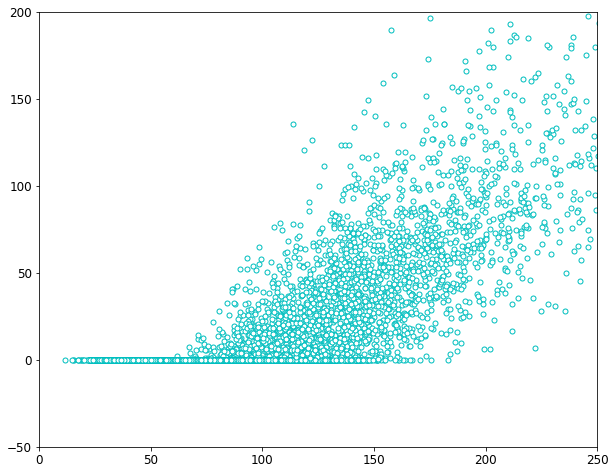

In [3]:
# display simulated data

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_xlim(0,250)
ax.set_ylim(-50,200)

ax.plot(X,Y, 'co', markersize=5, markerfacecolor="white")

<h3><center>Linear and polynomial regressions</center></h3>

Now we have a training set, we can train ML models. 

First, we train polynomial regression models. Recall, this is a linear regression over the monomials of $x$ up to some degree. Like for all linear models (where the prediction is a linear function of the weights), the solution is exact and unique, given by the well-known "normal equation". We could easily implement it ourselves, but this is a bit tedious (we must build all the monomials, etc.) and implemented in many standard libraries. We use the implementation of sklearn, wrapping it into a custom class for convenience.


In [4]:
# polynomial regression in sklearn
from sklearn.preprocessing import PolynomialFeatures  
from sklearn.linear_model import LinearRegression

# simple wrapper class for multi-dimensional polynomial regression
class PolyReg:
    
    def __init__(self, X, Y, degree):
        
        # create monomials
        self.features = PolynomialFeatures(degree = degree)  
        self.monomials = self.features.fit_transform(X)
        
        # regress with normal equation
        self.model = LinearRegression()  
        self.model.fit(self.monomials, Y)

    def predict(self, x):
        
        # predict with dot product
        monomials = self.features.fit_transform(x)
        return self.model.predict(monomials)

# run regressions of degree = 1 to 6
polyRegs = [PolyReg(X[:, np.newaxis], Y, degree) for degree in range(1,7)]
# the (perhaps curious) syntax X[:, np.newaxis] means 
# turn the vector X of shape [nSimul] into a matrix of shape [nSimul, 1]
# which is the same thing, but of the shape expected by sklearn

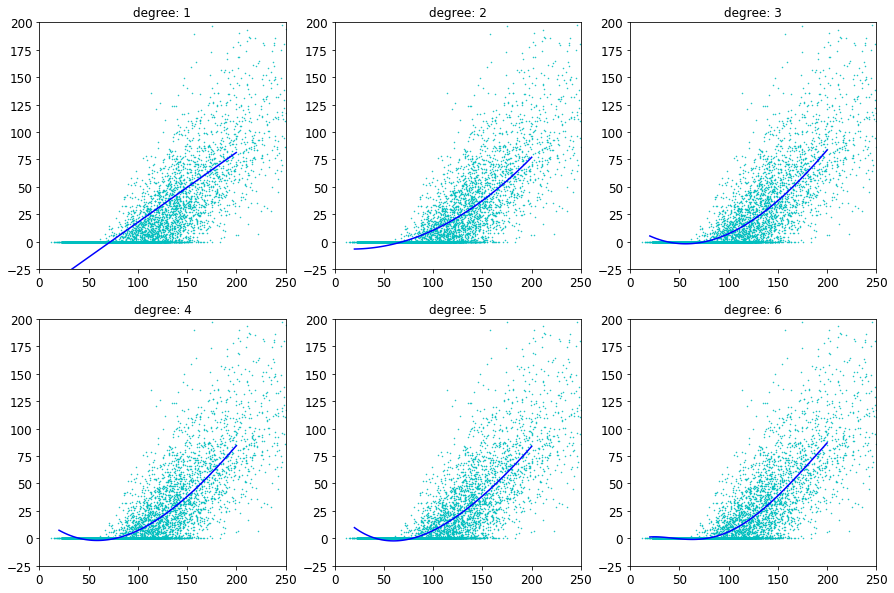

In [5]:
# compute and display results

# compute
xAxis = np.linspace(20, 200, 100)
poly = [polyReg.predict(xAxis[:, np.newaxis]) for polyReg in polyRegs]

# display
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(15, 10)
for i in [0,1]:
    for j in [0,1,2]:
        polIdx = 3*i + j
        ax[i, j].set_xlim(0,250)
        ax[i, j].set_ylim(-25,200)
        ax[i,j].set_title("degree: " + str(1 + polIdx))
        ax[i,j].plot(X,Y, 'c.', markersize=1)
        ax[i,j].plot(xAxis, poly[polIdx], 'b-')



<h3><center>Black & Scholes' formula</center></h3>

To assess accuracy, we implement Black & Scholes's formula, for our information only, to compare model predicitions with the correct results:

$$
B{S_{K,T,\sigma }}\left( S \right) = SN\left( {\frac{{\log \left( {\frac{S}{K}} \right) + \frac{{{\sigma ^2 T}}}{2}}}{\sigma \sqrt{T} }} \right) - KN\left( {\frac{{\log \left( {\frac{S}{K}} \right) - \frac{{{\sigma ^2 T}}}{2}}}{\sigma\sqrt{T} }} \right)
$$

In [6]:
from scipy.stats import norm # cumulative normal distribution

# general formula
def BlackScholes(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

# in our example, with fixed strike, vol and expiry
def bs(spot):
    return BlackScholes(spot, K, vol, T2 - T1)

# test
print("%.4f" % BlackScholes(100, 100, .1, 1.)) # 3.98

3.9828


We can now visualize the quality of the polynomial regressions:

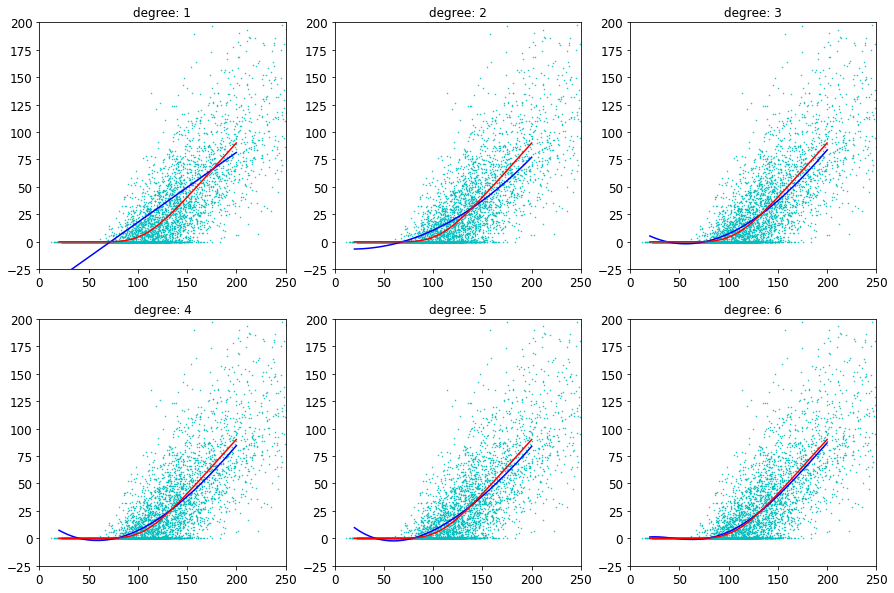

In [7]:
tgt = bs(xAxis)

# display
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(15, 10)
for i in [0,1]:
    for j in [0,1,2]:
        polIdx = 3*i + j
        ax[i, j].set_xlim(0,250)
        ax[i, j].set_ylim(-25,200)
        ax[i,j].set_title("degree: " + str(1 + polIdx))
        ax[i,j].plot(X,Y, 'c.', markersize=1)
        ax[i,j].plot(xAxis, poly[polIdx], 'b-')
        ax[i,j].plot(xAxis, tgt, 'r-')
        


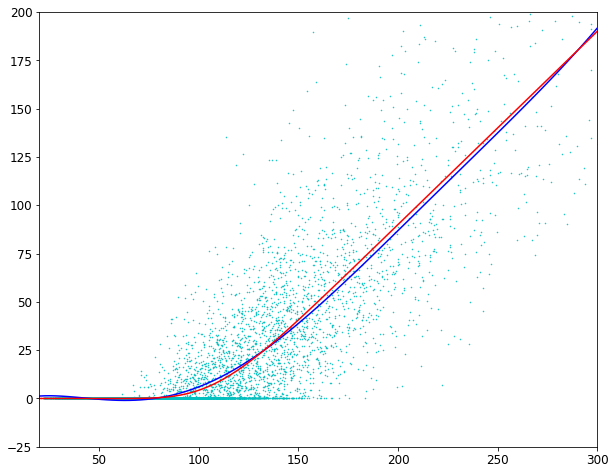

In [8]:
# a custom visualizer, freely set degree and limits  

# set here
degree = 6
xlim = (20, 300)
ymax = 200
#

# display
xs = np.linspace(xlim[0], xlim[1], 100)
ys = bs(xs)

polyReg = PolyReg(X[:, np.newaxis], Y, degree) 
polys = polyReg.predict(xs[:, np.newaxis]) 

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(-25,ymax)
ax.plot(X,Y, 'c.', markersize=1)
ax.plot(xs, polys, 'b-')
ax.plot(xs, ys, 'r-')

(With perhaps the exception of extrapolation) the performance is remarkable: the regression models don't know anything about Black & Scholes. All they see are the samples, a could of points that would look random to even experienced humans. Yet, the machine finds patterns in the data and identifies a function that approaches Black & Scholes to remarkable accuracy over a wide range of about 50-200 for such a simple method.

Note accuracy is not sufficient for pricing or risk management (although such accuracy can be achieved, with a much larger training set) but it enough for instance, for capital and risk simulations of large, complex trading books like Counterparty Value Adjustment (CVA).

<h3><center>Deep learning</center></h3>

We now implement a vanilla neural network to perform the regression in place of conventional linear or polynomial (or any other type of basis) regressions. Neural networks don't regress on a fixed set of basis functions, they learn the best functions (also known as features, or best representation in ML lingo), from the data, in their hidden layers, by composing activated combinations of previous layers. This is what allows neural networks to scale to high dimensional inputs, regressing on a low number of "best" representations, while the number of monomials (or any other kind of fixed basis functions) would increase exponentially in a conventional regression. With low dimensional problems like our simple example, we should expect neural nets to perform at least as well as conventional regression.

We implement a simple diamond-shaped network of the form:

<img src="net1.png">

where the input layer has a single input $S_1$, and we have a number of hidden layers so the net can learn to compose features for the regression on the final layer. We compute each layer from the previous layer with the classic feed-forward equation:

$$
{a^{\left[ l \right]}} = {elu}\left( {{W^{\left[ l \right]}}{a^{\left[ {l - 1} \right]}} + {b^{\left[ l \right]}}} \right)
$$

The output is computed by linear regression onto the basis functions in the final hidden layer. 

We activate the hidden layers with the ELU function $elu\left( x \right) = x{1_{\left\{ {x > 0} \right\}}} + \left( {{e^x} - 1} \right){1_{\left\{ {x \le 0} \right\}}}$. Another natural choice is the similar softplus function $softPlus\left( x \right) = \log \left( {1 + {e^x}} \right)$. ELU has been (empirically) shown to improve training over the classic $relu\left( x \right) = {x^ + }$. ELU has linear asymptotes, which is the desired behaviour in valuation problems: financial products are often linearly extrapolated and this behaviour is often enforced. For example, in finite difference methods, we generally work with linear boundary conditions. ELU is also considered a best practice presently in the deep learning community, for very different reasons related to speed and stability of numerical optimization.

In [9]:
# training works best in normalized space, so we normalized our inputs and labels 

meanX = np.mean(X)
stdX = np.std(X)
meanY = np.mean(Y)
stdY = np.std(Y)

normX = (X - meanX) / stdX
normY = (Y - meanY) / stdY

In [10]:
# start TensorFlow
import tensorflow as tf

# clear calculation graph
tf.reset_default_graph()

In [11]:
# inference = sequence of feed-forward equations from input to output 
# TensorFlow provides higher level function for all kinds of standard layers
# for vanilla layers, the function is tf.layers.dense() 

# the weights and biases are encapsulated and do not explicitly appear in the code

# the argument kernel_initializer allows to control the initialization of the weights
# (the biases are all initialized to 0)
# tf.variance_scaling_initializer() implements the Xavier-He initialization
# (centred Gaussian with variance 1.0 / num_inputs)
# widely considered an effective default, see e.g. Andrew Ng's DL spec on Coursera

def inference(xs):
    
    # hidden layers, note that the weights and biases are encpasulated in the tf functions
    a1 = tf.layers.dense(xs, 3, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    a2 = tf.layers.dense(a1, 5, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    a3 = tf.layers.dense(a2, 3, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    
    # output payer
    ys = tf.layers.dense(a3, 1, activation = None, kernel_initializer = tf.variance_scaling_initializer)
    
    return ys

In [12]:
# calculation graph for prediction and loss

# the instructions below don't calculate anything, they initialize a calculation graph in TensorFlow's memory space
# when the graph is complete, we can run it in a TensorFlow session, on CPU or GPU

# since TensorFlow knows the calculation graph, it will not only evaluate the results, but also the gradients, 
# very effectively, with the back-propagation equations

# reserve space for inputs and labels
inputs = tf.placeholder(shape=[None,1], dtype = tf.float32)
labels = tf.placeholder(shape=[None,1], dtype = tf.float32)

# calculation graphs for predictions given inputs and loss (= mean square error) given labels
predictions = inference(inputs)
loss = tf.losses.mean_squared_error(labels, predictions)

In [13]:
# definition of the optimizer
# the optimizer computes the gradient of loss to all weights and biases,
# and modifies them all by a small step (learning rate) in the direction opposite to the gradient
# in order to progressively decrease the loss and identify the set of weights that minimize it

learning_rate = 0.05
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate) # optimizer obejct
optimize = optimizer.minimize(loss) #  this op now computes gradient and moves weights
# the op 'optimize' performs one iteration of gradient descent

In [14]:
# we can display predictions before, during and after training
# to do this, we execute the inference result named 'predictions' on the session
# with some arbitrary inputs xs
def predict(xs):
    # first, normalize
    nxs = (xs - meanX) / stdX
    # forward feed through ANN
    nys = sess.run(predictions,feed_dict={inputs:np.reshape(nxs, [-1,1])})
    # de-normalize output
    ys = meanY + stdY * nys
    # we get a matrix of shape [size of xs][1], which we reshape as vector [size of xs]
    return np.reshape(ys, [-1])

In [15]:
# we can also display the resulting function 
# run the ann on the xaxis and compare to Black & Scholes 
def display(epoch):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    ax.set_xlim(0,250)
    ax.set_ylim(-25,200)
    plt.title("epoch: " + str(epoch))
    plt.plot(X,Y, 'c.', markersize=1)
    # call to predict() with inputs = xAxis
    # recall xAxis = grid over wide range of spots
    plt.plot(xAxis, predict(xAxis), 'b-')
    # recall tgt = black scholes applied to xAxis
    plt.plot(xAxis, tgt, 'r-')
    #
    plt.show()
    plt.close(fig)

In [16]:
# now the graph is in memory, TensorFlow's Session object can execute it on a session

# start the session
sess = tf.Session()

# initialize all variables (weights + biases on all layers)
sess.run(tf.global_variables_initializer())

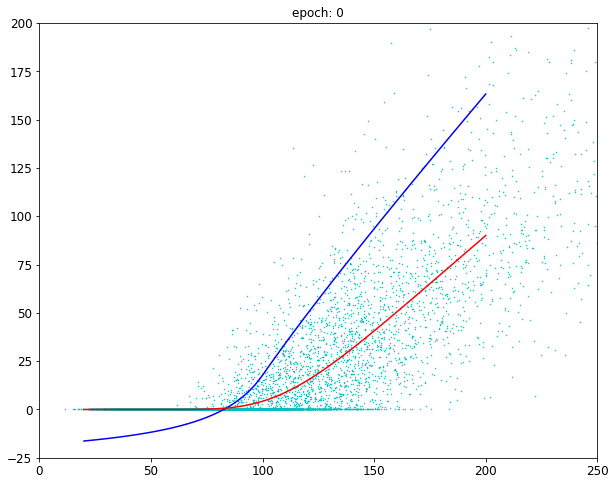

initial loss = 0.8836


In [17]:
# we want to compute the predictions and losses on the session
# remember the graph has some placeholders for inputs and labels
# we must feed actual values for those into the session

# this is performed with a Python dictionary of placeholder names to concrete values

# we train the network to best predict the ~normalized~ ys out of the ~normalized~ xs
feed_dict = {inputs:normX[:,np.newaxis], labels:normY[:,np.newaxis]}
# TensorFlow expects matrices (possibly with 1 column, not vectors, so we must reshape our vector data with np.newaxis)

# visualize the initial (random) function
display(0)

# compute and display the initial loss
print ("initial loss = %.4f" % sess.run(loss, feed_dict=feed_dict))

In [18]:
# run the optimizer once
# note that TensorFlow silently abd efficiently computes the gradient by back-propagation along the calculation graph
sess.run(optimize, feed_dict=feed_dict)

improved loss = 0.2892


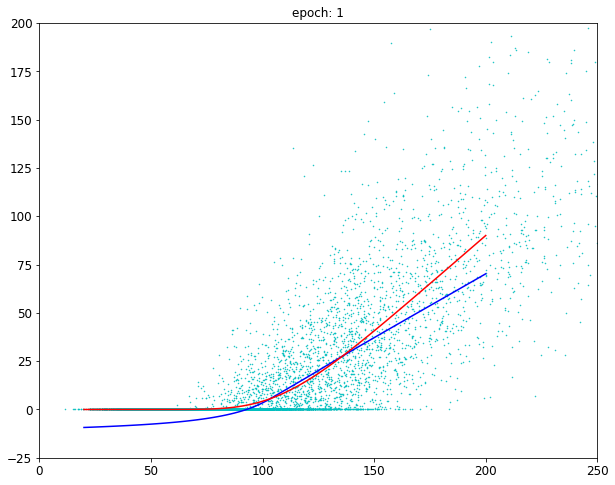

In [19]:
# recalculate loss, it is now lower due to moving the weights
print ("improved loss = %.4f" % sess.run(loss, feed_dict=feed_dict))

# and see the (slightly) improved function representation
display(1)

final loss = 0.2145


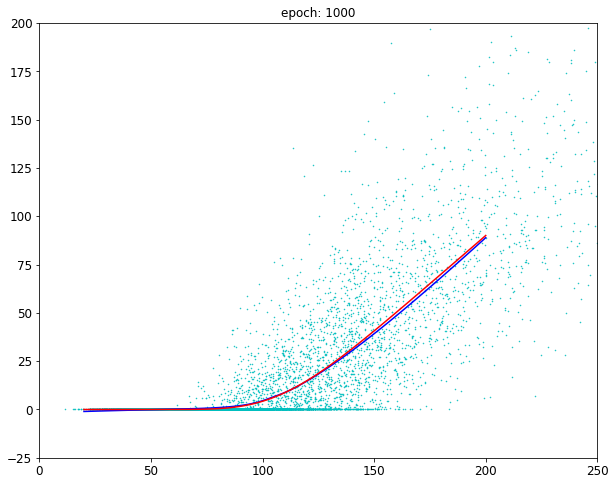

In [20]:
# run the optimizer a few times (called epochs)
epochs = 1000

# we save results after each epoch for visualization
yAxes = [] 

# re-initialize
sess.run(tf.global_variables_initializer())

# go
for _ in range(epochs):
    yAxes.append(predict(xAxis))
    sess.run(optimize, feed_dict=feed_dict)

# and see improved results
print ("final loss = %.4f" % sess.run(loss, feed_dict=feed_dict))
display(epochs)

# note computation time is not representative, most of the time is spent saving results for visualization
# training alone completes in a fraction of a second

We applied a few iterations of the naive gradient descent (GD) algorithm, which is nice for pedagogy because it is easy to understand. It is also effective enough for our simple problem. But this is not current best practice in Deep Learning.

Best practice is train by mini-batch, that is, compute gradients and update weights, not with the entire training set, but a small subset of it (say, 256 samples). This way, updates are applied faster while the estimated gradient that is applied is unbiased (correct in expectation). This is called stochastic gradient descent (SGD) and converges under the same conditions as GD.

Further, best practice is replace standard gradient descent with heuristic improvements, like ADAM (see Wikipedia en.wikipedia.org/wiki/Stochastic_gradient_descent or Deep Learning spec on Coursera). These improvements compute gradients in the same way but apply them differently, with  notions like momentum (apply weighted average of recent gradients rather than current) or adaptative leraning rates (typically, normalized by recent standard deviation of gradients in different dimensions).

In [22]:
# create animation to better visualize how the model learns

# create figure
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_xlim(0,250)
ax.set_ylim(-25,200)
ax.plot(X,Y, 'c.', markersize=1)
ax.plot(xAxis, tgt, 'r-')
ax.set_title("epoch = 0")
line, = ax.plot(xAxis, yAxes[0], 'b-')

def anim_init():
    ax.set_title("epoch = 0")
    line.set_ydata(yAxes[0])
    return line, 

def anim_update(i):
    ax.set_title("epoch = " + str(i+1))
    line.set_ydata(yAxes[i])
    return line, 

def frames():
    for i in range(49):
        yield i
    for i in range(49, 99, 10):
        yield i
    for i in range(99, epochs, 50):
        yield i
    

anim = animation.FuncAnimation(fig, anim_update, init_func = anim_init, 
                               frames=frames, interval = 40, blit=True, repeat=False)
plt.close(fig)

anim

The performance is generally similar to polynomial regression. The main benefit of deep learning is that it scales to high dimensional inputs, while the number of basis functions in conventional regression grows exponentially with the dimension of the input vector. In this example, dimension is 1 so neural nets don't make much difference, although it is interesting to visualize how they learn, and this also allowed us to implement our first ANN in a particularly simple context.

Next, we repeat the experiement with higher dimensional basket options.

In [23]:
sess.close()